This example shows how to use the IMU Mocap library to generate joint angles from raw Xsens IMU recordings.

__Inputs:__
- IMU recordings exported by Xsens MT Manager. One .txt file per each sensor. The required information are:
    - Orientation in matrix format
    - Rate of turn (i.e., gyroscope readings)
    - Acceleration (i.e., acceleromet readings)
    - Magnetic field (i.e., magnetometer readings)

    In MT Manager 4.6, you can select what inofrmation to export in Tools &rarr; Preferences &rarr; Exporters. In this example, the exported raw data are located at IMUData subfolder. We also need to know the sampling rate of IMU measurements. When using MT Manager 4.6, this information can be found at the header part of the exported files.
- An IMU mapping xml file, where each IMU is mapped to a segment in the used OpenSim model. See here for more info. In this example, the file is named `myIMUMappings.xml`.
- An OpenSim model .osim file.

__Output:__
- Generated .mot file containing joint angle time series for all joints defined in the OpenSim model.



### Step 1: Generating OpenSim storage files from raw measurements
In the first step, we read the raw IMU data exported from Xsens MT Manager and store them into four OpenSim storage files including accelerometer, gyroscope and magnetometer raw recordings and processed orientations (in quaternions).

In [2]:
import opensim as osim

# Build an Xsens Settings Object. 
# Instantiate the Reader Settings Class
xsensSettings = osim.XsensDataReaderSettings('myIMUMappings.xml')
# Instantiate an XsensDataReader
xsens = osim.XsensDataReader(xsensSettings)
# Read in seprate tables of data from the specified IMU file(s)
tables = xsens.read('./IMUData/')
# get the trial name from the settings
trial = xsensSettings.get_trial_prefix()
# Get Orientation Data as quaternions
quatTable = xsens.getOrientationsTable(tables)
# Write to file
osim.STOFileAdapterQuaternion.write(quatTable, trial + '_orientations.sto')
# Get Acceleration Data
accelTable = xsens.getLinearAccelerationsTable(tables)
# Write to file
osim.STOFileAdapterVec3.write(accelTable, trial + '_linearAccelerations.sto')
# Get Magnetic (North) Heading Data
magTable = xsens.getMagneticHeadingTable(tables)
# Write to file
osim.STOFileAdapterVec3.write(magTable, trial + '_magneticNorthHeadings.sto')
# Get Angular Velocity Data
angVelTable = xsens.getAngularVelocityTable(tables)
# Write to file
osim.STOFileAdapterVec3.write(angVelTable, trial + '_angularVelocities.sto')

### Step 2: Generate improved IMU orientations using VQF filter
In the second step, we use offline VQF sensor fusion algorithm to generate improved IMU orientations and store it as an OpenSim storage file.

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from pathlib import Path
from imu_tools import *

FS_IMU = 100 # IMU sampling frequency
base_imu_label = 'pelvis_imu' # the label of the base IMU to align with the global Y axis (forward direction)
heading_axis = [0, 0, -1] # the axis of the base IMU that points in the forward direction
# VQF parameters; you may want to tune these for your data
# see https://vqf.readthedocs.io/en/latest/ref_cpp_params.html for more details
vqf_params = {'restMinT': 0.5, 'restFilterTau': 0.1, 'restThGyr': 3, 'restThAcc': 1,
              'magNormTh': 0.2, 'magRefTau': 10.0, 'magNewTime': 5.0, 'magNewFirstTime': 1.0}
path_imu = Path(trial + "_orientations.sto")
rots_imu = RotationTable(path_imu)
# VQF IMU orientation estimation; you can replace this with your own algorithm
t_vqf, rots_imu_vqf9D = XsensVQF(path_imu.parent, trial, 1/FS_IMU, is9D=True, params=vqf_params)
rots_imu_vqf9D = RotationTable(table=rots_imu_vqf9D, t=t_vqf, meta=rots_imu.meta) # retain the metadata from the original table
print("Calculated orientation data for the following segments:")
print(rots_imu_vqf9D.segs)
# align to OpenSim global coordinate system
heading = rots_imu_vqf9D[base_imu_label][0].as_matrix() @ heading_axis # get the heading of the first frame of the base IMU
heading[2] = 0 # set the z component to zero
heading /= np.linalg.norm(heading) # and normalize
# rotate to align the initial heading with the global X axis and the up direction with the global Y axis
rot_align = R.from_matrix([[heading[0],  heading[1], 0],
                           [0,           0,          1],
                           [heading[1], -heading[0], 0]])
rots_imu_vqf9D = rots_imu_vqf9D.rotate(rot_align)
# save to file
rots_imu_vqf9D.write_to_STO(path_imu.with_name(path_imu.stem+'_corrected.sto'))

Calculated orientation data for the following segments:
dict_keys(['torso_imu', 'pelvis_imu', 'tibia_r_imu', 'femur_r_imu', 'tibia_l_imu', 'femur_l_imu', 'calcn_r_imu', 'calcn_l_imu'])


### Step 3: Calculate joint angles using Inverse Kinematics method
Next, we use OpenSim's IMU Inverse Kinematics tool to generate joint angles and save them in a .mot file.

In [7]:
model_file = './gait2354_simbody_FDOF.osim'
orientations_file = trial + '_orientations_corrected.sto'
output_file = trial + '_ik.mot'
calibration_file = None # this is optional; if not provided, the first frame of orientations_file will be used as the calibration frame
heading = False # if True, the base IMU will be used to set the heading axis
base_imu_label = 'pelvis_imu' # the label of the base IMU to align with the global Y axis (forward direction)
heading_axis = '-z' # the axis of the base IMU to align with the global Y axis (forward direction): 'x', 'y', 'z' or '-x', '-y', '-z'

print('Running IMU IK...')
print(f'Input model: {model_file}')
print(f'Input orientations: {orientations_file}')
print(f'Output motion: {output_file}')

imuPlacer = osim.IMUPlacer()
imuPlacer.set_model_file(model_file)
if calibration_file:
    imuPlacer.set_orientation_file_for_calibration(calibration_file)
else:
    imuPlacer.set_orientation_file_for_calibration(orientations_file)
if heading:
    imuPlacer.set_base_imu_label(base_imu_label)
    imuPlacer.set_base_heading_axis(heading_axis)
imuPlacer.run()
model = imuPlacer.getCalibratedModel()

imuIK = osim.IMUInverseKinematicsTool()
imuIK.setModel(model)
imuIK.set_orientations_file(orientations_file)
imuIK.set_results_directory('./')
imuIK.setOutputMotionFileName(output_file)
imuIK.run()

Running IMU IK...
Input model: ./gait2354_simbody_FDOF.osim
Input orientations: MT_01200585-021-000_orientations_corrected.sto
Output motion: MT_01200585-021-000_ik.mot


True

### Step 4: Plotting and analysis

IMU IK output coordinates: ['time', 'pelvis_rotation', 'pelvis_list', 'pelvis_tilt', 'pelvis_tx', 'pelvis_ty', 'pelvis_tz', 'hip_FE_r', 'hip_AA_r', 'hip_IE_r', 'knee_FE_r', 'knee_AA_r', 'knee_IE_r', 'ankle_FE_r', 'ankle_AA_r', 'ankle_IE_r', 'subtalar_angle_r', 'mtp_angle_r', 'hip_FE_l', 'hip_AA_l', 'hip_IE_l', 'knee_FE_l', 'knee_AA_l', 'knee_IE_l', 'ankle_FE_l', 'ankle_AA_l', 'ankle_IE_l', 'subtalar_angle_l', 'mtp_angle_l', 'lumbar_extension', 'lumbar_bending', 'lumbar_rotation']


Text(0.5, 1.0, 'Joint angle: knee_FE_r')

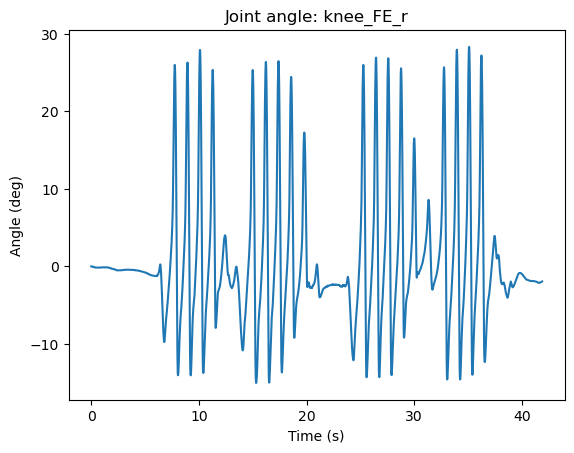

In [23]:
(mt_imu, dt_imu) = get_data_from_mot(output_file)
coords = list(mt_imu['cols'])
print(f'IMU IK output coordinates: {coords}')
t_idx = coords.index('time')
t = dt_imu[:, t_idx]
joint = 'knee_FE_r'
joint_idx = coords.index(joint)
joint_angle = dt_imu[:, joint_idx]

plt.plot(t, joint_angle)
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title(f'Joint angle: {joint}')